In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Flatten(),
            nn.Linear(128 * 24 * 4, 512),
            nn.LeakyReLU(self.leaky_slope),
            nn.Linear(512, self.latent_dim)
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(128, 32),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope

        self.initial_layer = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(512, 128 * 8 * 8),
            nn.LeakyReLU(leaky_slope)
        )
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_slope),
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(leaky_slope),
            
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = x.view(-1, 128, 8, 8)
        x = self.conv_layers(x)
        return x  # Output shape: [batch_size, 3, 64, 64]
    

class FullModel(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01):
        super(FullModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, leaky_slope)
        self.decoder = Decoder(latent_dim, leaky_slope)
        self.discriminator = Discriminator(latent_dim, leaky_slope)

    def forward(self, x):
        z = self.encoder(x)
        
        decoded = self.decoder(z)
        
        d_fake = self.discriminator(z)
        
        real_distribution = torch.randn_like(z)
        d_real = self.discriminator(real_distribution)
        
        return decoded, z, d_fake, d_real

class PairedNpyDataset(Dataset):
    def __init__(self, input_dir, output_dir):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))
        assert len(self.input_files) == len(self.output_files), "Mismatch in number of input and output files"

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])
        
        input_data = np.load(input_path)
        output_data = np.load(output_path)
        
        # Ensure the data is in the correct shape and type
        input_data = torch.from_numpy(input_data).float().permute(2, 0, 1)  # Assuming shape is (384, 64, 3)
        output_data = torch.from_numpy(output_data).float().permute(2, 0, 1)  # Assuming shape is (64, 64, 3)
        
        return input_data, output_data
    

input_dir = r"H:\DDGAN\plus_mask\norm_input"
output_dir = r"H:\DDGAN\plus_mask\norm_d_pm"

dataset = PairedNpyDataset(input_dir, output_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

model = FullModel()  # Your model definition
optimizer = optim.Adam(model.parameters(), lr=0.0002)
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

def train_step(input_data, real_sample):
    # Forward pass
    decoded, z, d_fake, d_real = model(input_data)
    
    # Reconstruction loss
    recon_loss = mse_loss(decoded, real_sample)
    
    # Adversarial loss
    real_labels = torch.ones_like(d_real)
    fake_labels = torch.zeros_like(d_fake)
    
    d_loss_real = bce_loss(d_real, real_labels)
    d_loss_fake = bce_loss(d_fake, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = bce_loss(d_fake, real_labels)
    
    # Total loss
    total_loss = recon_loss + 0.001 * g_loss
    
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    return total_loss, recon_loss, d_loss, g_loss

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (input_data, real_samples) in enumerate(dataloader):
        input_data = input_data.to(device)  # Assuming you're using GPU
        real_samples = real_samples.to(device)
        
        loss, recon_loss, d_loss, g_loss = train_step(input_data, real_samples)
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], "
                  f"Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, "
                  f"D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")

    # Optionally, save the model after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')

Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2838413..0.2533612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3851492..0.37856].


Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])
Input shape: torch.Size([3, 384, 64]), Output shape: torch.Size([3, 64, 64])

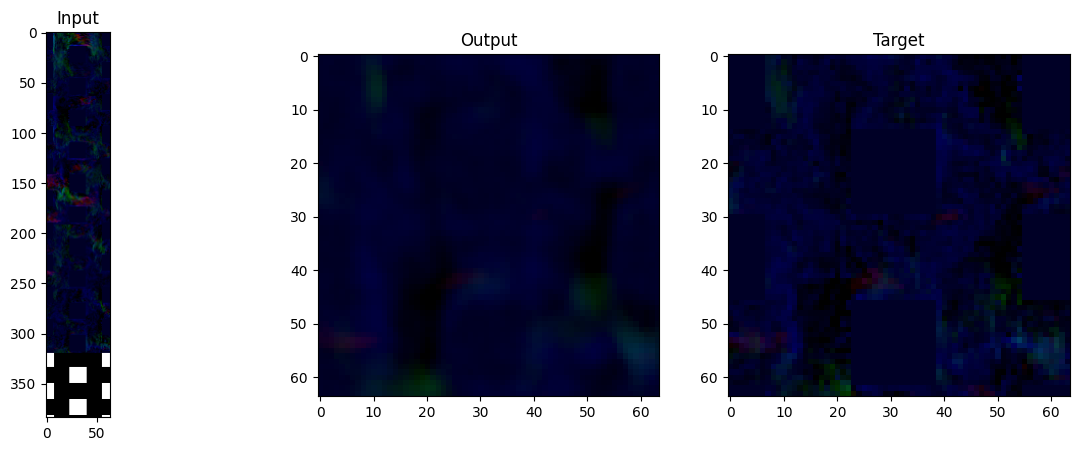

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30719012..0.32649806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4207621..0.5540981].


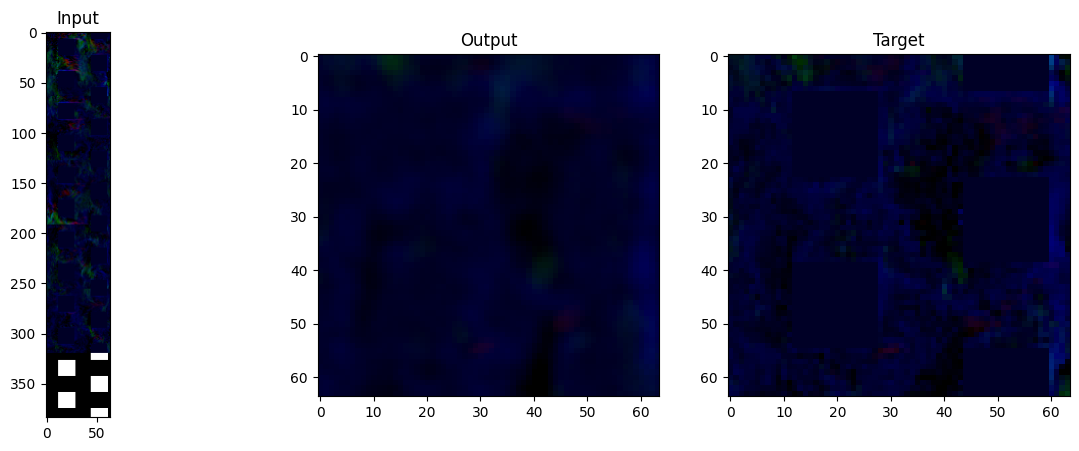

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33085757..0.34217405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41601762..0.43807778].


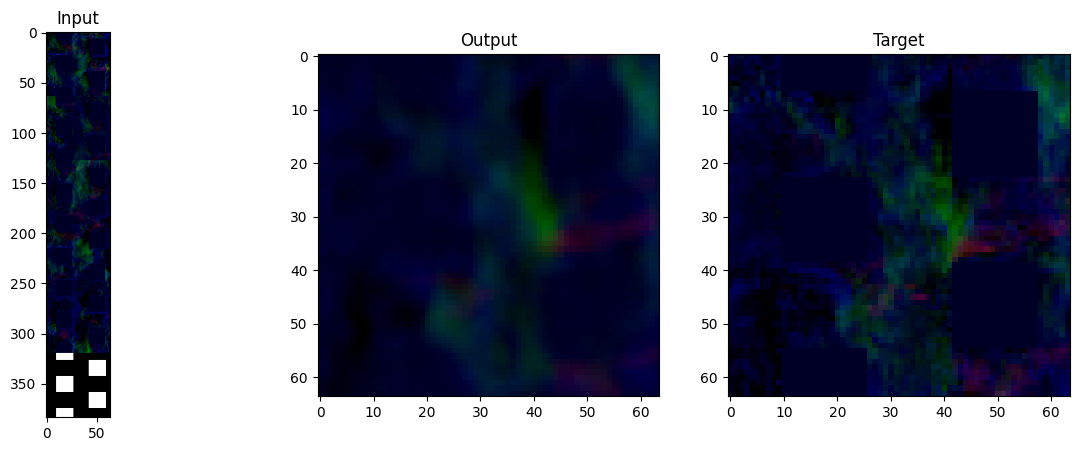

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33522585..0.31342864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3984498..0.48673913].


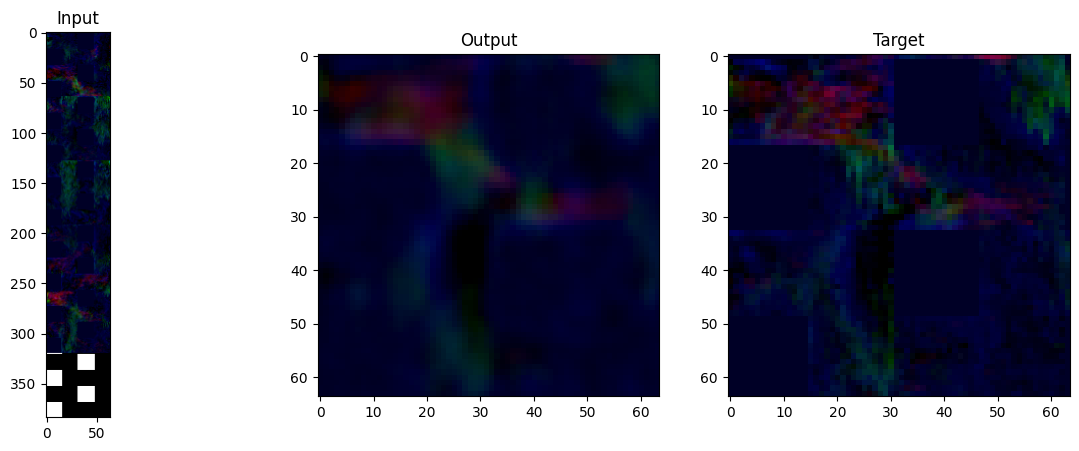

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3434401..0.34329024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50760216..0.4714083].


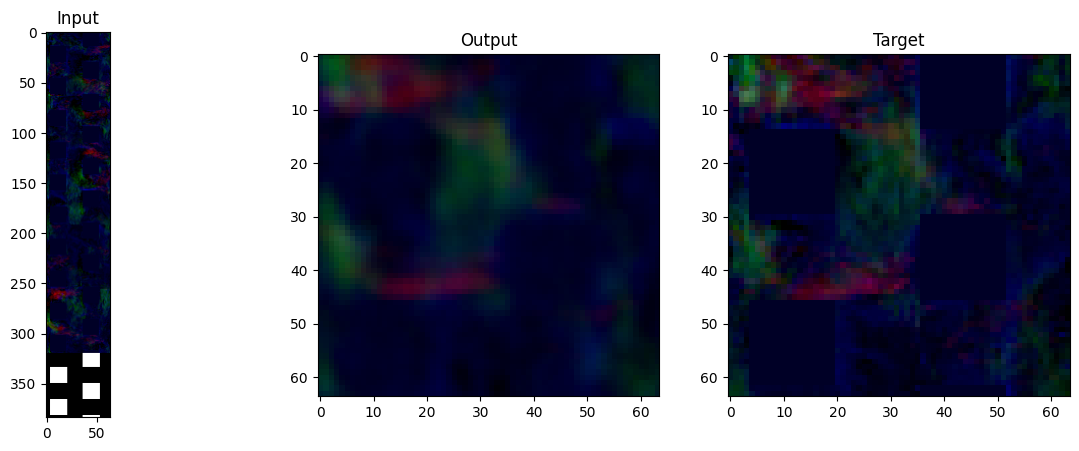

In [8]:
import torch
from test1 import FullModel  # Import your model architecture

# Load the model
model = FullModel()
model.load_state_dict(torch.load(r'H:\DDGAN\model_epoch_99.pth'))
model.eval()  # Set the model to evaluation mode

# If you're using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


from torch.utils.data import DataLoader
from test1 import PairedNpyDataset

# Assuming you have a separate test set
test_input_dir = r"H:\DDGAN\plus_mask\norm_input"
test_output_dir = r"H:\DDGAN\plus_mask\norm_d_pm"
test_dataset = PairedNpyDataset(test_input_dir, test_output_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch.nn as nn
import numpy as np
from skimage.metrics import structural_similarity as ssim

mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)


def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    num_samples = 0

    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            # Forward pass
            output, _, _, _ = model(input_data)

            # Calculate MSE
            mse = mse_loss(output, target_data)
            total_mse += mse.item() * input_data.size(0)

            # Calculate PSNR and SSIM
            output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
            target_np = target_data.cpu().numpy().transpose(0, 2, 3, 1)
            
            print(f"Output shape: {output_np.shape}")  # Add this line
            print(f"Target shape: {target_np.shape}")  # Add this line
            
            for i in range(output_np.shape[0]):
                total_psnr += calculate_psnr(output_np[i], target_np[i])
                total_ssim += calculate_ssim(output_np[i], target_np[i])

            num_samples += input_data.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples

    return avg_mse, avg_psnr, avg_ssim

# Run evaluation
avg_mse, avg_psnr, avg_ssim = evaluate_model(model, test_loader, device)
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

import matplotlib.pyplot as plt

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            output, _, _, _ = model(input_data)

            # Convert to numpy for visualization
            input_np = input_data.cpu().numpy()
            target_np = target_data.cpu().numpy()
            output_np = output.cpu().numpy()

            for i in range(num_samples):
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 2, 1)
                plt.imshow(output_np[i].transpose(1, 2, 0))
                plt.title("Output")
                
                plt.subplot(1, 2, 2)
                plt.imshow(target_np[i].transpose(1, 2, 0))
                plt.title("Target")
                
                plt.show()

            break  # Only process one batch

visualize_results(model, test_loader, device)


Average MSE: 0.0008
Average PSNR: 79.0232
Average SSIM: 0.8694


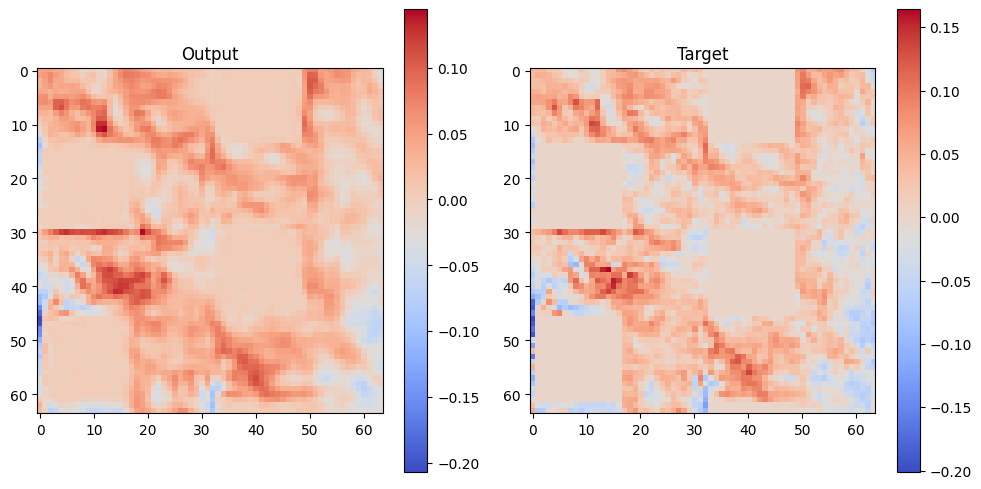

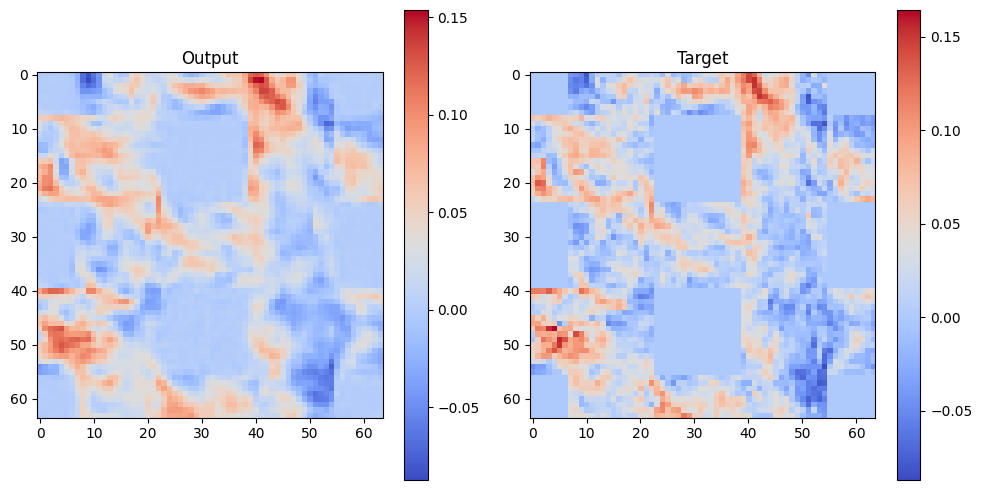

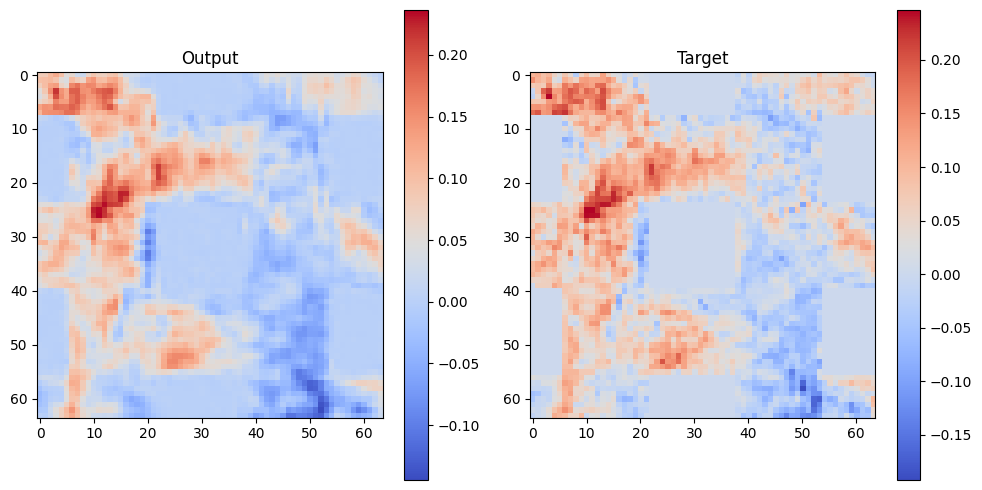

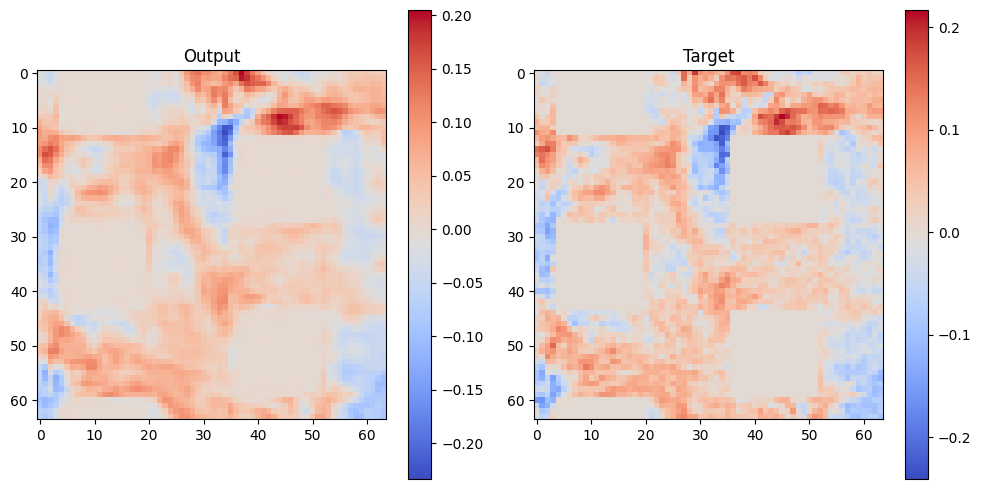

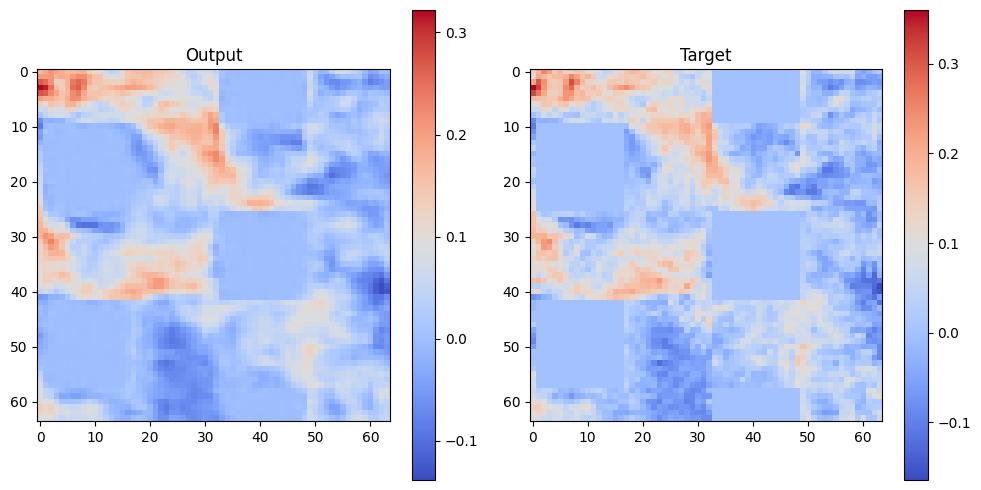

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from nine_1 import FullModel  # Import your model architecture
from nine_1 import PairedNpyDataset  # Import your dataset class

# Load the model
model = FullModel()
# model.load_state_dict(torch.load(r'H:\DDGAN\pm_100_epcoh_testing.pth'))
model.load_state_dict(torch.load(r'H:\DDGAN\nine_gird_model\model_epoch_3000.pth'))             # change
model.eval()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare your evaluation data
test_input_dir = r"H:\DDGAN\nine_grid\norm_g_ng"                               # change
test_output_dir = r"H:\DDGAN\nine_grid\norm_d_ng"                               # change
test_dataset = PairedNpyDataset(test_input_dir, test_output_dir)    
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define evaluation metrics
mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    num_samples = 0

    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            # Forward pass
            output, _, _, _ = model(input_data)

            # Calculate MSE
            mse = mse_loss(output, target_data)
            total_mse += mse.item() * input_data.size(0)

            # Calculate PSNR and SSIM
            output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
            target_np = target_data.cpu().numpy().transpose(0, 2, 3, 1)
            
            for i in range(output_np.shape[0]):
                total_psnr += calculate_psnr(output_np[i], target_np[i])
                total_ssim += calculate_ssim(output_np[i], target_np[i])

            num_samples += input_data.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples

    return avg_mse, avg_psnr, avg_ssim

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            output, _, _, _ = model(input_data)

            # Convert to numpy for visualization
            output_np = output.cpu().numpy()
            target_np = target_data.cpu().numpy()

            for i in range(min(num_samples, output_np.shape[0])):
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.imshow(output_np[i].mean(axis=0), cmap='coolwarm')
                plt.title("Output")
                plt.colorbar()
                
                plt.subplot(1, 2, 2)
                plt.imshow(target_np[i].mean(axis=0), cmap='coolwarm')
                plt.title("Target")
                plt.colorbar()
                
                plt.tight_layout()
                plt.show()

            break  # Only process one batch

# Run evaluation
avg_mse, avg_psnr, avg_ssim = evaluate_model(model, test_loader, device)
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Visualize results
visualize_results(model, test_loader, device)

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim=512, leaky_slope=0.01):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.leaky_slope),
            
            nn.Flatten(),
            nn.Linear(512 * 9 * 1, 1024),
            nn.LeakyReLU(self.leaky_slope),
            nn.Linear(1024, self.latent_dim)
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=512, leaky_slope=0.01):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(256, 128),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(128, 64),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=512, leaky_slope=0.01):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope

        self.initial_layer = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.LeakyReLU(leaky_slope),
            nn.Linear(1024, 512 * 4 * 4),
            nn.LeakyReLU(leaky_slope)
        )
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_slope),
            
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = x.view(-1, 512, 4, 4)
        x = self.conv_layers(x)
        return x  # Output shape: [batch_size, 3, 64, 64]
    

class FullModel(nn.Module):
    def __init__(self, latent_dim=512, leaky_slope=0.01):
        super(FullModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, leaky_slope)
        self.decoder = Decoder(latent_dim, leaky_slope)
        self.discriminator = Discriminator(latent_dim, leaky_slope)

    def forward(self, x):
        z = self.encoder(x)
        
        decoded = self.decoder(z)
        
        d_fake = self.discriminator(z)
        
        real_distribution = torch.randn_like(z)
        d_real = self.discriminator(real_distribution)
        
        return decoded, z, d_fake, d_real
    
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullModel(latent_dim=512, leaky_slope=0.01).to(device)
 
summary(model, (3, 576, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 288, 32]             896
       BatchNorm2d-2          [-1, 32, 288, 32]              64
         LeakyReLU-3          [-1, 32, 288, 32]               0
            Conv2d-4          [-1, 64, 144, 16]          18,496
       BatchNorm2d-5          [-1, 64, 144, 16]             128
         LeakyReLU-6          [-1, 64, 144, 16]               0
            Conv2d-7           [-1, 128, 72, 8]          73,856
       BatchNorm2d-8           [-1, 128, 72, 8]             256
         LeakyReLU-9           [-1, 128, 72, 8]               0
           Conv2d-10           [-1, 256, 36, 4]         295,168
      BatchNorm2d-11           [-1, 256, 36, 4]             512
        LeakyReLU-12           [-1, 256, 36, 4]               0
           Conv2d-13           [-1, 512, 18, 2]       1,180,160
      BatchNorm2d-14           [-1, 512

In [4]:
import torch
import matplotlib
print(torch.__config__.show())
device = torch.device("cpu")
print(device)
import sklearn
print(matplotlib.__version__)


PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930151
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.8.1  (built against CUDA 12.0)
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.8.1, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /Zc:__cplusplus /

MSE: 0.0010
PSNR: 78.3118
SSIM: 0.7198
Shape of output_untransformed: (64, 64, 3)
Data saved to evaluation_results.mat


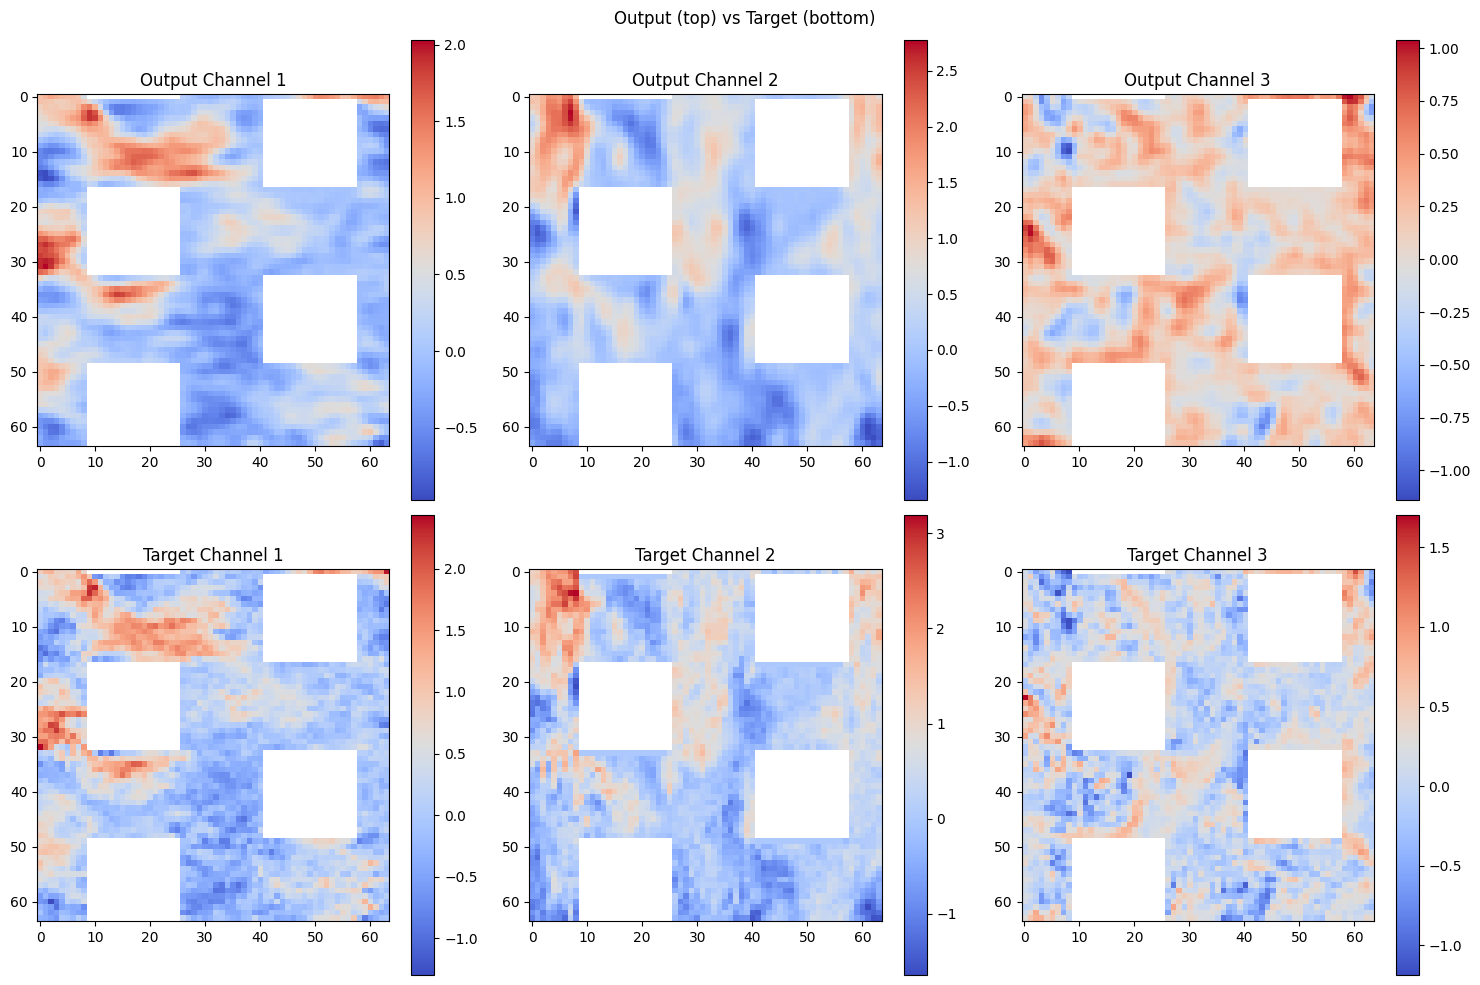

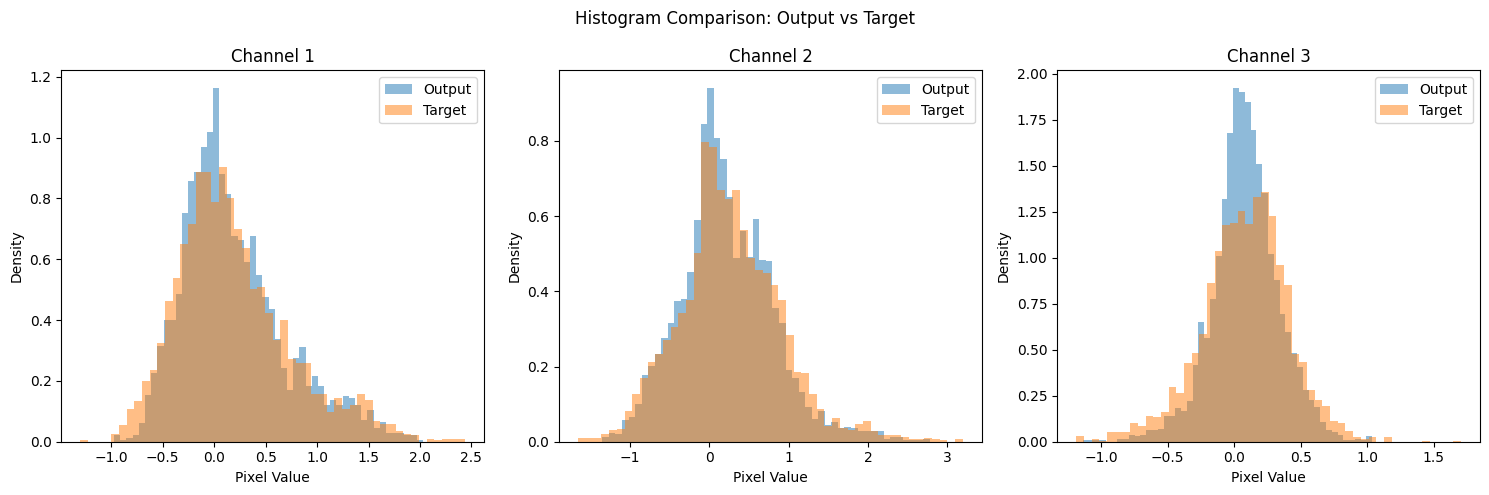

In [9]:
import torch
import pickle
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from plus_2 import FullModel  # Import your model architecture
from scipy import io as sio
import os
import glob
from torch.utils.data import DataLoader, Dataset
import re

# Load the model
model = FullModel()
# model.load_state_dict(torch.load(r'H:\DDGAN\nine_gird_model\model_final.pth'))
# model.load_state_dict(torch.load(r'H:\DDGAN\plus_mask_model\model_epoch_3900.pth'))
# model.eval()
class CustomScaler:
    def __init__(self):
        self.u_min = float('inf')
        self.u_max = float('-inf')
    
    def partial_fit(self, batch):
        batch_min = np.min(batch)
        batch_max = np.max(batch)
        self.u_min = min(self.u_min, batch_min)
        self.u_max = max(self.u_max, batch_max)
    
    def fit(self, data_loader):
        for i, batch in enumerate(data_loader):
            self.partial_fit(batch.numpy())
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Current min: {self.u_min:.6f}, Current max: {self.u_max:.6f}")
    
    def transform(self, u):
        u_scaled = (2 * u - (self.u_max + self.u_min)) / (self.u_max - self.u_min)
        return np.clip(u_scaled, -1, 1)
    
    def untransform(self, u_scaled):
        return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

class GANDataset(Dataset):
    def __init__(self, folder_path, prefix):
        self.folder_path = folder_path
        self.prefix = prefix
        self.num_timesteps = 5000  # 0 to 4999

    def __len__(self):
        return self.num_timesteps

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, f'{self.prefix}_sample_{idx}.npy')
        data = np.load(file_path)
        return torch.from_numpy(data[0]).float()  # u = [0], v = [1] , w = [2]                       <--

def create_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def save_scaler(scaler, path):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def fit_scaler(gen_folder_path, disc_folder_path, scaler_path, batch_size = 5000):                     # <--
    print(f"Fitting scaler with batch size: {batch_size}")
    scaler = CustomScaler()

    # Create DataLoaders
    gen_dataset = GANDataset(gen_folder_path, 'g')
    disc_dataset = GANDataset(disc_folder_path, 'd')

    gen_loader = create_dataloader(gen_dataset, batch_size)
    disc_loader = create_dataloader(disc_dataset, batch_size)

    # Fit the single scaler on both datasets
    print("Fitting scaler on generator data...")
    scaler.fit(gen_loader)
    print("Fitting scaler on discriminator data...")
    scaler.fit(disc_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    return scaler
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define evaluation metrics
mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (64, 3, 576):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, output_np, target_np

def visualize_results_3channels(output, target):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Output (top) vs Target (bottom)')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        # Output image
        im = axs[0, i].imshow(output[:,:,i], cmap='coolwarm')
        axs[0, i].set_title(f'Output {channel_names[i]}')
        fig.colorbar(im, ax=axs[0, i])
        
        # Target image
        im = axs[1, i].imshow(target[:,:,i], cmap='coolwarm')
        axs[1, i].set_title(f'Target {channel_names[i]}')
        fig.colorbar(im, ax=axs[1, i])
    
    plt.tight_layout()
    plt.show()

def plot_histograms(output, target):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Histogram Comparison: Output vs Target')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        axs[i].hist(output[:,:,i].flatten(), bins=50, alpha=0.5, label='Output', density=True)
        axs[i].hist(target[:,:,i].flatten(), bins=50, alpha=0.5, label='Target', density=True)
        axs[i].set_title(f'{channel_names[i]}')
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

def compute_histograms(image):
    histograms = []
    for i in range(3):
        hist, _ = np.histogram(image[:,:,i].flatten(), bins=50,range=(-6, 6), density=True)
        histograms.append(hist)
    return np.array(histograms)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (3, 384, 64):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    # Now we can safely access input_tensor
    input_np = input_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, input_np, output_np, target_np

# Specify the input and target file paths
input_file = r"H:\DDGAN\nine_grid_testing\g_1_1.npy"  # Replace with your input file path
target_file = r"H:\DDGAN\nine_grid_testing\g_1_1.npy"  # Replace with your target file path
mask = np.load(r'H:\DDGAN\plus_mask\norm_h_pm\norm_h_sample_123.npy')

model = FullModel()
model.load_state_dict(torch.load(r'H:\DDGAN\plus_mask_model\model_epoch_3900.pth'))
model.eval()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Run evaluation
mse, psnr, ssim_value, input_data, output_data, target_data = evaluate_single_file(model, input_file, target_file, device)
print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f}")
print(f"SSIM: {ssim_value:.4f}")

# Visualize results with all 3 channels
# visualize_results_3channels(output, target)

scaler_u = load_scaler(r'H:\DDGAN\scaler_u.pkl')
scaler_v = load_scaler(r'H:\DDGAN\scaler_v.pkl')
scaler_w = load_scaler(r'H:\DDGAN\scaler_w.pkl')

if mask.shape[0] == 1:
    mask = np.squeeze(mask, axis=0)

def untransform(self, u_scaled):
    return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

# Assuming scaler_u, scaler_v, scaler_w are instances of Scaler
# and output_data is your 3D array with shape (3, height, width)
output_u=output_data[:,:,0]
output_v=output_data[:,:,1]
output_w=output_data[:,:,2]
output_u = scaler_u.untransform(output_u)
output_v = scaler_v.untransform(output_v)
output_w = scaler_w.untransform(output_w)
output_u[mask > 0] = np.nan
output_v[mask > 0] = np.nan
output_w[mask > 0] = np.nan
# Merge the untransformed data back into a 3D array
output_untransformed = np.stack((output_u, output_v, output_w), axis=0)
output_masked = output_untransformed.transpose(1,2,0)
print(f"Shape of output_untransformed: {output_masked.shape}")


target_data = np.load(target_file)
target_u = scaler_u.untransform(target_data[0])
target_v = scaler_v.untransform(target_data[1])
target_w = scaler_w.untransform(target_data[2])
target_u[mask > 0] = np.nan
target_v[mask > 0] = np.nan
target_w[mask > 0] = np.nan
target_data = np.stack((target_u, target_v, target_w), axis=0)
target_data = target_data.transpose(1,2,0)
# Compute histograms
input_hist = compute_histograms(input_data)
output_hist = compute_histograms(output_data)
target_hist = compute_histograms(target_data)

# Plot histograms
# plot_histograms(output, target)

matlab_data = {
    'input_data': input_data,
    'output_data': output_data,
    'output_data_unnorm': output_masked,
    'target_data': target_data,
    'input_hist': input_hist,
    'output_hist': output_hist,
    'target_hist': target_hist,
    'mse': mse,
    'psnr': psnr,
    'ssim': ssim_value
}

# sio.savemat('evaluation_results_pm.mat', matlab_data)
print("Data saved to evaluation_results.mat")

# Visualize results with all 3 channels
# visualize_results_3channels(output_data, target_data)
visualize_results_3channels(output_masked, target_data)

# Plot histograms
plot_histograms(output_masked, target_data)

Average MSE: 0.0073
Average PSNR: 69.5579
Average SSIM: 0.2557


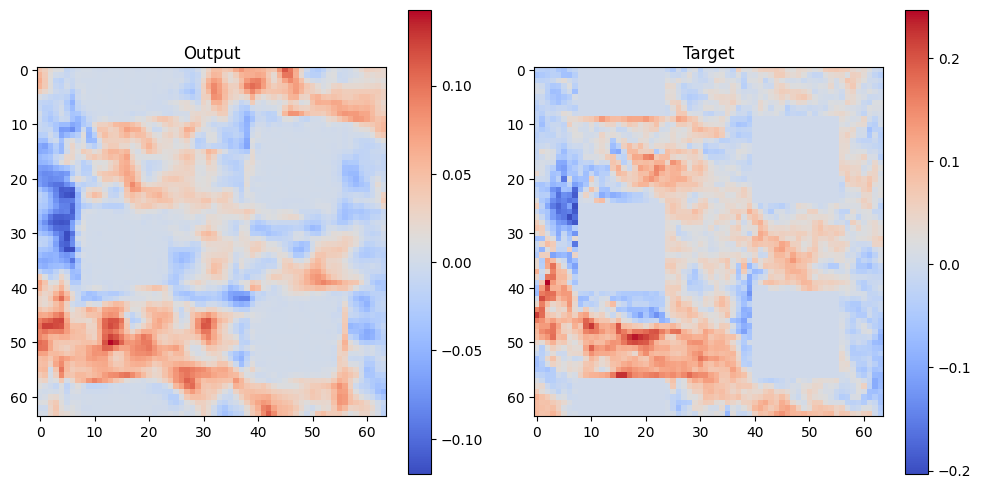

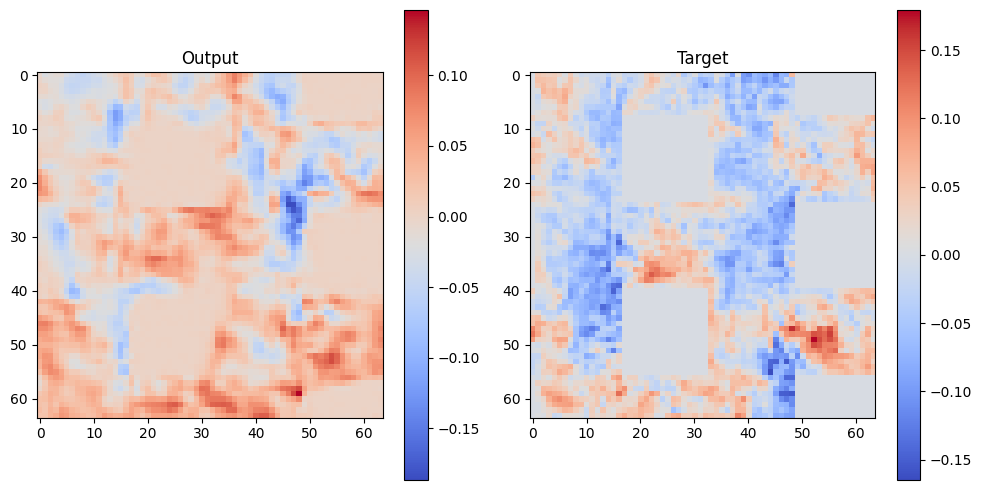

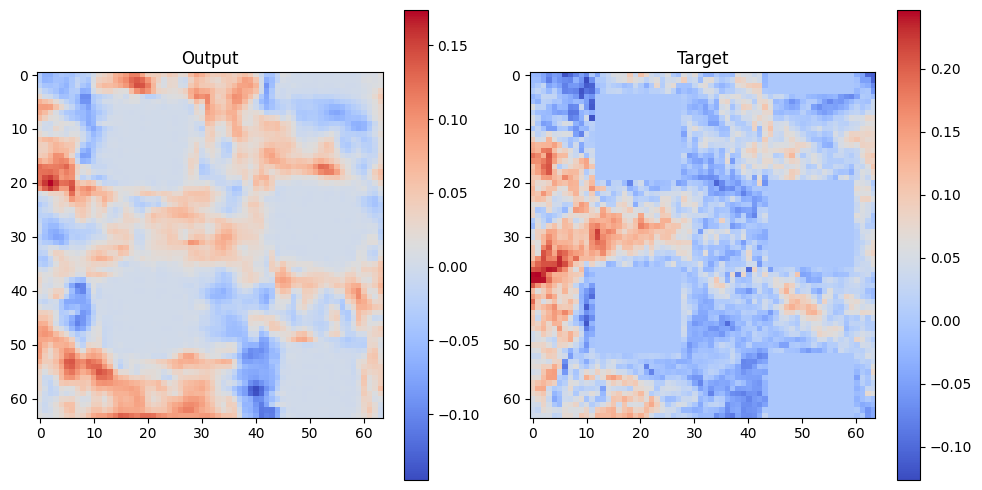

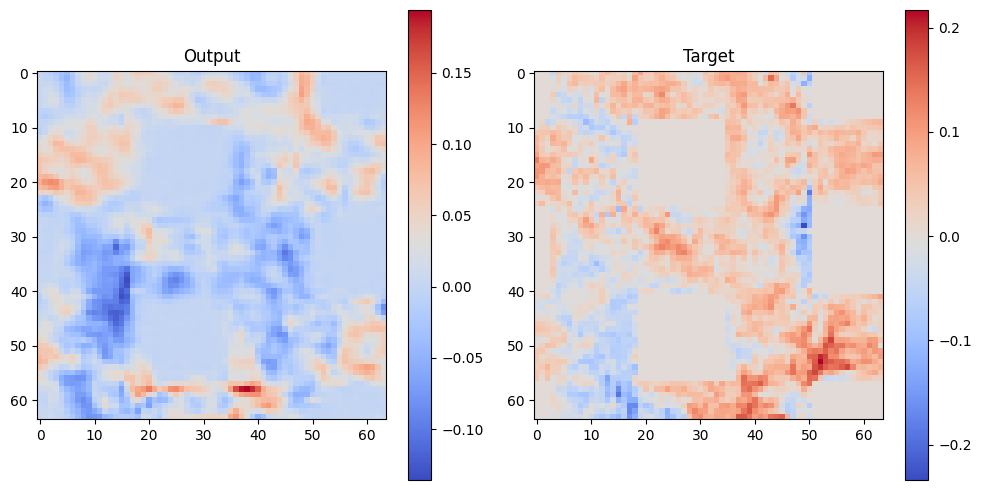

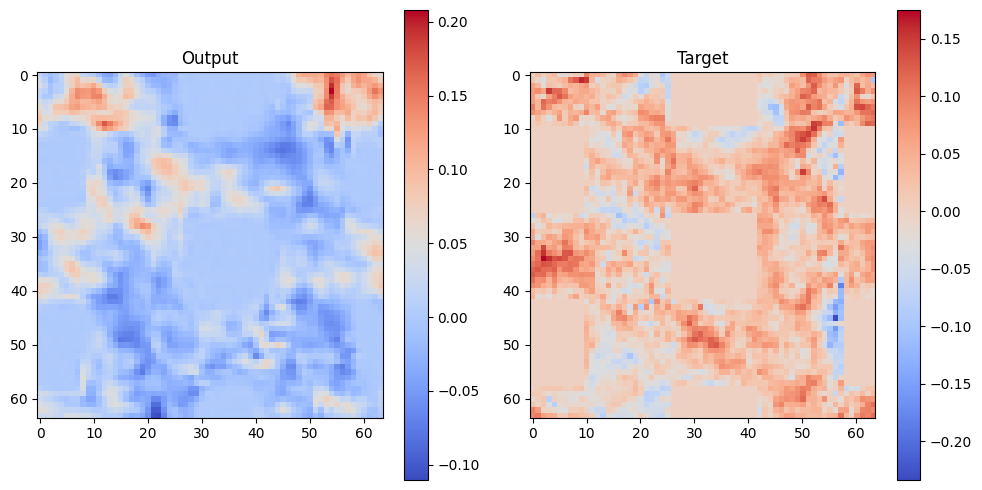

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from nine_1 import FullModel  # Import your model architecture
from nine_1 import PairedNpyDataset  # Import your dataset class

# Load the model
model = FullModel()
# model.load_state_dict(torch.load(r'H:\DDGAN\pm_100_epcoh_testing.pth'))
model.load_state_dict(torch.load(r'H:\DDGAN\nine_gird_model\model_epoch_3000.pth'))             # change
model.eval()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare your evaluation data
test_input_dir = r"H:\DDGAN\nine_grid_unseen\norm_g_ng"                               # change
test_output_dir = r"H:\DDGAN\nine_grid_unseen\norm_d_ng"                               # change
test_dataset = PairedNpyDataset(test_input_dir, test_output_dir)    
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define evaluation metrics
mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    num_samples = 0

    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            # Forward pass
            output, _, _, _ = model(input_data)

            # Calculate MSE
            mse = mse_loss(output, target_data)
            total_mse += mse.item() * input_data.size(0)

            # Calculate PSNR and SSIM
            output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
            target_np = target_data.cpu().numpy().transpose(0, 2, 3, 1)
            
            for i in range(output_np.shape[0]):
                total_psnr += calculate_psnr(output_np[i], target_np[i])
                total_ssim += calculate_ssim(output_np[i], target_np[i])

            num_samples += input_data.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples

    return avg_mse, avg_psnr, avg_ssim

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for input_data, target_data in dataloader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            output, _, _, _ = model(input_data)

            # Convert to numpy for visualization
            output_np = output.cpu().numpy()
            target_np = target_data.cpu().numpy()

            for i in range(min(num_samples, output_np.shape[0])):
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.imshow(output_np[i].mean(axis=0), cmap='coolwarm')
                plt.title("Output")
                plt.colorbar()
                
                plt.subplot(1, 2, 2)
                plt.imshow(target_np[i].mean(axis=0), cmap='coolwarm')
                plt.title("Target")
                plt.colorbar()
                
                plt.tight_layout()
                plt.show()

            break  # Only process one batch

# Run evaluation
avg_mse, avg_psnr, avg_ssim = evaluate_model(model, test_loader, device)
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Visualize results
visualize_results(model, test_loader, device)

MSE: 0.0075
PSNR: 69.3605
SSIM: 0.2623
Shape of output_untransformed: (64, 64, 3)
Data saved to evaluation_results.mat


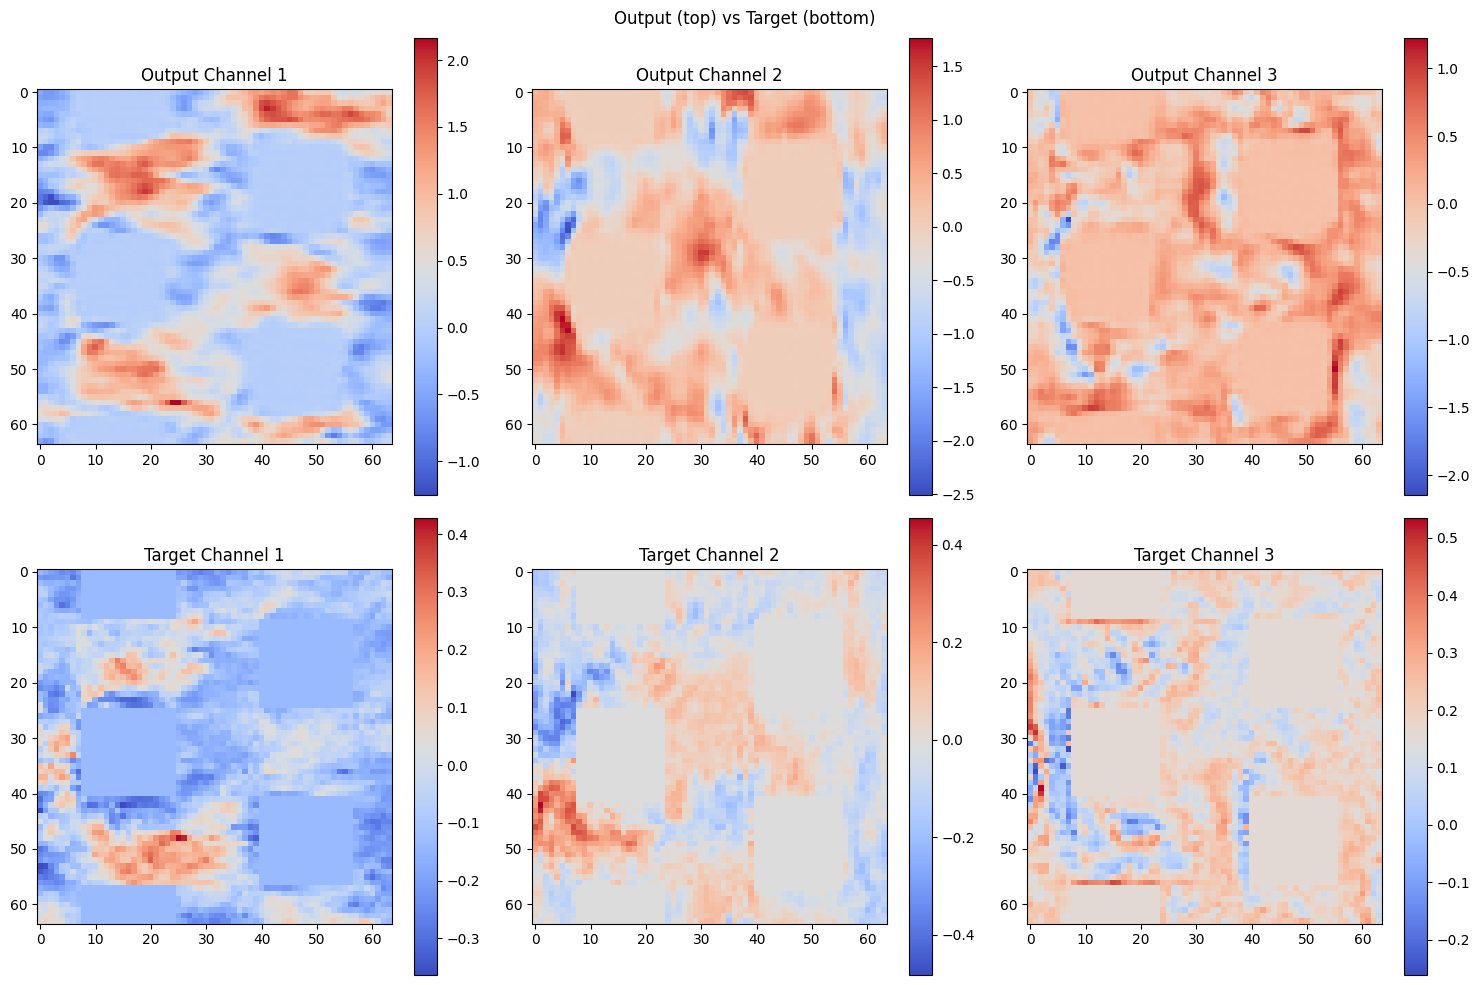

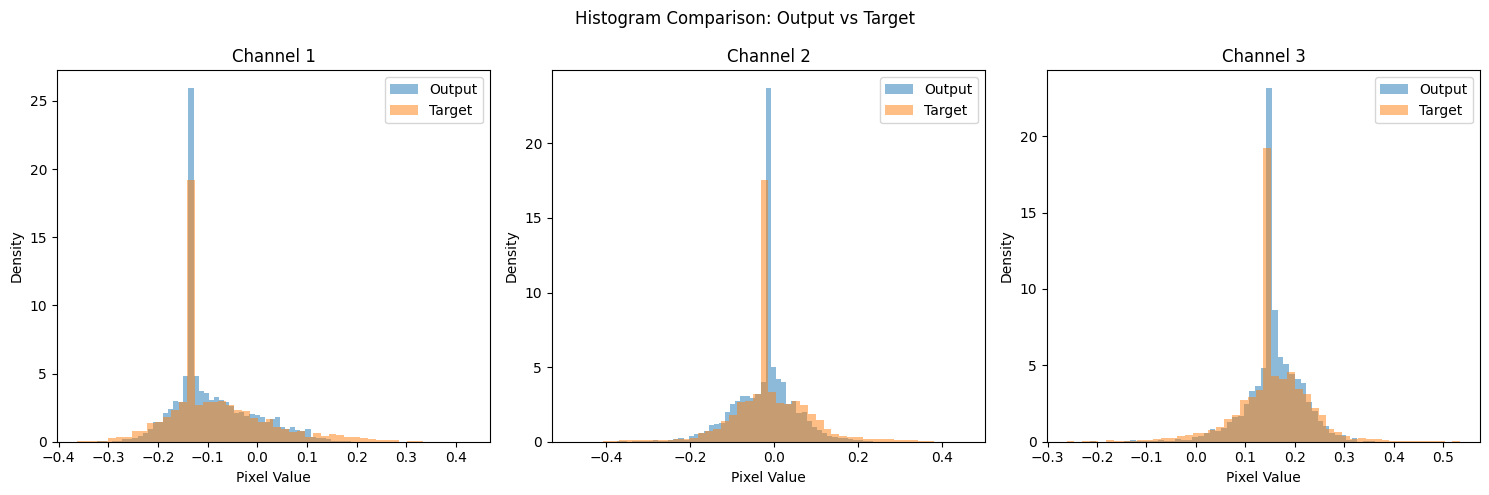

In [1]:
import torch
import pickle
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from nine_1 import FullModel  # Import your model architecture
from scipy import io as sio
import os
import glob
from torch.utils.data import DataLoader, Dataset
import re

# Load the model
model = FullModel()
# model.load_state_dict(torch.load(r'H:\DDGAN\nine_gird_model\model_final.pth'))
# model.load_state_dict(torch.load(r'H:\DDGAN\plus_mask_model\model_epoch_3900.pth'))
# model.eval()
class CustomScaler:
    def __init__(self):
        self.u_min = float('inf')
        self.u_max = float('-inf')
    
    def partial_fit(self, batch):
        batch_min = np.min(batch)
        batch_max = np.max(batch)
        self.u_min = min(self.u_min, batch_min)
        self.u_max = max(self.u_max, batch_max)
    
    def fit(self, data_loader):
        for i, batch in enumerate(data_loader):
            self.partial_fit(batch.numpy())
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Current min: {self.u_min:.6f}, Current max: {self.u_max:.6f}")
    
    def transform(self, u):
        u_scaled = (2 * u - (self.u_max + self.u_min)) / (self.u_max - self.u_min)
        return np.clip(u_scaled, -1, 1)
    
    def untransform(self, u_scaled):
        return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

class GANDataset(Dataset):
    def __init__(self, folder_path, prefix):
        self.folder_path = folder_path
        self.prefix = prefix
        self.num_timesteps = 5000  # 0 to 4999

    def __len__(self):
        return self.num_timesteps

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, f'{self.prefix}_sample_{idx}.npy')
        data = np.load(file_path)
        return torch.from_numpy(data[0]).float()  # u = [0], v = [1] , w = [2]                       <--

def create_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def save_scaler(scaler, path):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def fit_scaler(gen_folder_path, disc_folder_path, scaler_path, batch_size = 5000):                     # <--
    print(f"Fitting scaler with batch size: {batch_size}")
    scaler = CustomScaler()

    # Create DataLoaders
    gen_dataset = GANDataset(gen_folder_path, 'g')
    disc_dataset = GANDataset(disc_folder_path, 'd')

    gen_loader = create_dataloader(gen_dataset, batch_size)
    disc_loader = create_dataloader(disc_dataset, batch_size)

    # Fit the single scaler on both datasets
    print("Fitting scaler on generator data...")
    scaler.fit(gen_loader)
    print("Fitting scaler on discriminator data...")
    scaler.fit(disc_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    return scaler
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define evaluation metrics
mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (64, 3, 576):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, output_np, target_np

def visualize_results_3channels(output, target):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Output (top) vs Target (bottom)')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        # Output image
        im = axs[0, i].imshow(output[:,:,i], cmap='coolwarm')
        axs[0, i].set_title(f'Output {channel_names[i]}')
        fig.colorbar(im, ax=axs[0, i])
        
        # Target image
        im = axs[1, i].imshow(target[:,:,i], cmap='coolwarm')
        axs[1, i].set_title(f'Target {channel_names[i]}')
        fig.colorbar(im, ax=axs[1, i])
    
    plt.tight_layout()
    plt.show()

def plot_histograms(output, target):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Histogram Comparison: Output vs Target')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        axs[i].hist(output[:,:,i].flatten(), bins=50, alpha=0.5, label='Output', density=True)
        axs[i].hist(target[:,:,i].flatten(), bins=50, alpha=0.5, label='Target', density=True)
        axs[i].set_title(f'{channel_names[i]}')
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

def compute_histograms(image):
    histograms = []
    for i in range(3):
        hist, _ = np.histogram(image[:,:,i].flatten(), bins=50, density=True)
        histograms.append(hist)
    return np.array(histograms)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (64, 3, 576):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    # Now we can safely access input_tensor
    input_np = input_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, input_np, output_np, target_np

# Specify the input and target file paths
input_file = r"H:\DDGAN\nine_grid_unseen\norm_g_ng\norm_g_sample_0.npy"  # Replace with your input file path
target_file = r"H:\DDGAN\nine_grid_unseen\norm_d_ng\norm_d_sample_0.npy"  # Replace with your target file path

model = FullModel()
model.load_state_dict(torch.load(r'H:\DDGAN\models\jz_hpc_5000_test_ng.pth'))
model.eval()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Run evaluation
mse, psnr, ssim_value, input_data, output_data, target_data = evaluate_single_file(model, input_file, target_file, device)
print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f}")
print(f"SSIM: {ssim_value:.4f}")

# Visualize results with all 3 channels
# visualize_results_3channels(output, target)

scaler_u = load_scaler(r'H:\DDGAN\scaler_u.pkl')
scaler_v = load_scaler(r'H:\DDGAN\scaler_v.pkl')
scaler_w = load_scaler(r'H:\DDGAN\scaler_w.pkl')


def untransform(self, u_scaled):
    return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

# Assuming scaler_u, scaler_v, scaler_w are instances of Scaler
# and output_data is your 3D array with shape (3, height, width)
output_u=output_data[:,:,0]
output_v=output_data[:,:,1]
output_w=output_data[:,:,2]
output_u = scaler_u.untransform(output_u)
output_v = scaler_v.untransform(output_v)
output_w = scaler_w.untransform(output_w)

# Merge the untransformed data back into a 3D array
output_untransformed = np.stack((output_u, output_v, output_w), axis=0)
output_masked = output_untransformed.transpose(1,2,0)
print(f"Shape of output_untransformed: {output_masked.shape}")

#for channel in range(output_untransformed.shape):
#    output_data[:, :, channel][mask == 1] = 0

target_data = np.load(target_file)
target_data = target_data.transpose(1,2,0)
# Compute histograms
input_hist = compute_histograms(input_data)
output_hist = compute_histograms(output_data)
target_hist = compute_histograms(target_data)

# Plot histograms
# plot_histograms(output, target)

matlab_data = {
    'input_data': input_data,
    'output_data': output_data,
    'output_data_unnorm': output_masked,
    'target_data': target_data,
    'input_hist': input_hist,
    'output_hist': output_hist,
    'target_hist': target_hist,
    'mse': mse,
    'psnr': psnr,
    'ssim': ssim_value
}

sio.savemat('evaluation_results.mat', matlab_data)
print("Data saved to evaluation_results.mat")

# Visualize results with all 3 channels
# visualize_results_3channels(output_data, target_data)
visualize_results_3channels(output_masked, target_data)

# Plot histograms
plot_histograms(output_data, target_data)